<a href="https://colab.research.google.com/github/nhdchicken/nhd-colab/blob/master/notebooks/inference/maskrcnnButtonsInferenceTF2.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mask R-CNN Demo on Buttons dataset**


> A quick intro to using the pre-trained model to detect the UI buttons.





This experiment is performed on colab so mount the nhdchicken drive.

In [1]:
%%bash
if [  -d "/content/nhd-colab" ]
then
   echo "Environment already initialized"
elif [ -d "/content" ] && [ ! -d "/content/nhd-colab" ]
then
    cd /content || exit 1;
    echo "Installing https://github.com/nhdchicken/nhd-colab.git"
    git clone --recurse-submodules https://github.com/nhdchicken/nhd-colab.git || exit 1;
    cd nhd-colab || exit 1;
else
    echo "Not running in Colab - going to root of repos"
    cd `git rev-parse --show-toplevel` || exit 1;
fi
pwd
pip install utils/nhdcolab/ > /dev/null 2>&1 || exit 1;
nhdcolab > /dev/null 2>&1 || exit 1;
echo "Great Success!"

Installing https://github.com/nhdchicken/nhd-colab.git
Submodule path 'mask-rcnn/matterport': checked out '3deaec5d902d16e1daf56b62d5971d428dc920bc'
Submodule path 'yolov4/tensorf': checked out '2b8099f09170f41620da47ca48111b8f39cc4f3f'
/content/nhd-colab
Great Success!


Cloning into 'nhd-colab'...
Submodule 'mask-rcnn/matterport' (https://github.com/matterport/Mask_RCNN) registered for path 'mask-rcnn/matterport'
Submodule 'yolov4/tensorflow' (https://github.com/hunglc007/tensorflow-yolov4-tflite) registered for path 'yolov4/tensorf'
Cloning into '/content/nhd-colab/mask-rcnn/matterport'...
Cloning into '/content/nhd-colab/yolov4/tensorf'...


In [2]:
!nhdcolab init mp-mask-rcnn

Running in Colab
NHD_COLAB_REPOS_ROOT=/content/nhd-colab OK!
Google Drive not mounted
going to repos root dir /content/nhd-colab
loading install config /content/nhd-colab/install.yml
installing components
>>> processing patch group tensorflow_2
mp-mask-rcnn:requirements creating patch /content/nhd-colab/mask-rcnn/matterport/requirements.txt  OK!
mp-mask-rcnn:model creating patch /content/nhd-colab/mask-rcnn/matterport/mrcnn/model.py  OK!
mp-mask-rcnn:utils creating patch /content/nhd-colab/mask-rcnn/matterport/mrcnn/utils.py  OK!
>>> processing patch group tensorflow_2
mp-mask-rcnn:requirements installing patch /content/nhd-colab/patches/matterport-mrcnn/AmanTF2.2/requirements.txt.patch on /content/nhd-colab/mask-rcnn/matterport/requirements.txt  OK!
mp-mask-rcnn:model installing patch /content/nhd-colab/patches/matterport-mrcnn/AmanTF2.2/model.py.patch on /content/nhd-colab/mask-rcnn/matterport/mrcnn/model.py  OK!
mp-mask-rcnn:utils installing patch /content/nhd-colab/patches/matterpo

In [3]:
from nhdcolab.environment import NHDEnvironment
NHD_ENV = NHDEnvironment(gdrive_mount=True)

Running in Colab
NHD_COLAB_REPOS_ROOT=/content/nhd-colab OK!
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Move to Mask_RCNN directory on the drive

In [4]:
cd mask-rcnn/matterport/

/content/nhd-colab/mask-rcnn/matterport


Import the required libraries

In [5]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import imutils
import random
import cv2
import os
from keras.models import load_model
%matplotlib inline
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


We create a myMaskRCNNConfig class for training on the buttons dataset. It is derived from the base Mask R-CNN Config class and overrides some values.

In [6]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1+2
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.003
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

Create an instance of the myMaskRCNNConfig class

In [7]:
config = myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.003
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Detecting objects in the image with masks and bounding box from the trained model and displaying the results



Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


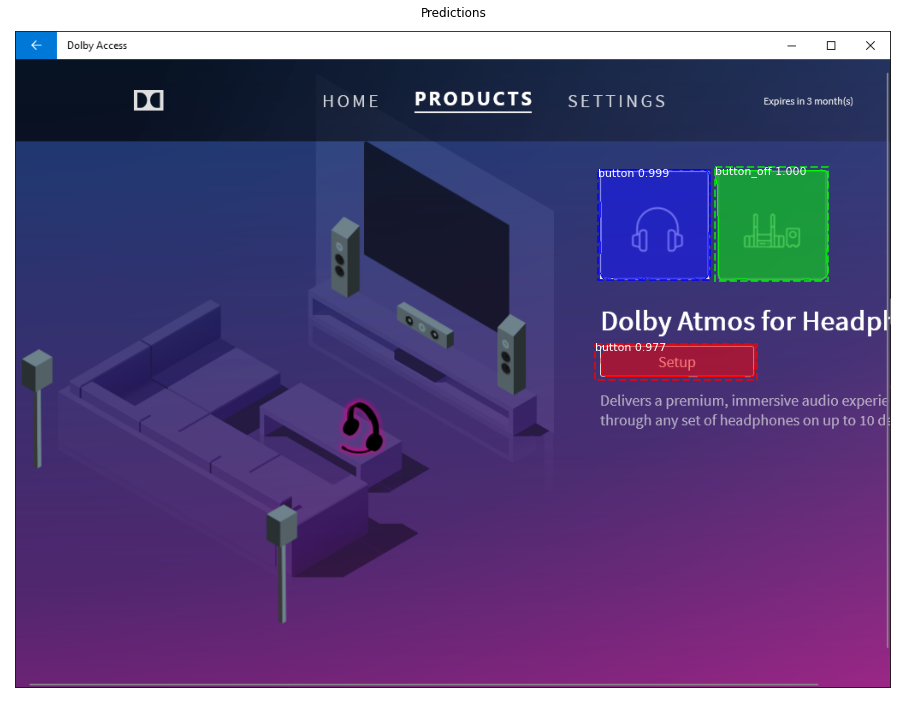

In [10]:
class_names=['BG','button', 'button_off']
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
model_path = '..//..//..//drive//My Drive//models//mask-rcnn//maskrcnn_Buttons_TF2.2Epoch25Lr0.03.h5'
# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)
img = load_img("..//..//..//drive//My Drive//Buttons//sample-images/EnableDolby__HP__2YConfDAHT__1024x768.png")
img = img_to_array(img)

results= model.detect([img],verbose=1)
# Display results

r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'], 
                            title="Predictions")
